# 連続放電における放電開始時の濃度を確認する

In [45]:
from os.path import join
import pandas as pd
import aklab.qulee as qulee
import numpy as np
import matplotlib.pyplot as plt
from quest_pp_calibration.convert_qms_time import t2sa

plt.rcParams["font.weight"] = "normal"
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "regular"

In [46]:
kd = 5.0e-31

shot_start = 34313
shot_end = 34320
date = 170112
csv_path = "../../data/raw/pdp8_csv/S1_170112_091831.CSV"

In [47]:
# 02_calc_pumping_time/calc_pumping_time_170123.ipynb
kqms = {8:2.91e+22} 
tau = {8:31.16}

# m^2 surface area
A = {8:7.5e-03}

### 取得データの時間計算

指定したショット番号からデータを抽出する時間を取得

In [48]:
# 抽出する時間を計算

pp_pth = f'../../data/raw/pdp8_shot_txt'
filename1 = f'{shot_start} PDP 8.txt'

df1 = pd.read_csv(join(pp_pth,filename1),delimiter='\t')

start_time = df1[df1.columns[2]][0]
end_time = '002:10:14.968'

qms = qulee.QMS(csv_path)
qms.load_data()
df_qms = qms.data

start_time = t2sa([start_time])
end_time = t2sa([end_time])

In [49]:
shot_start_list = []
shot_duration = [20,20,20,60,60,60,60,300]
shot_list = list(range(shot_start, shot_end+1))
for shot in shot_list:
    shot_df = pd.read_csv(join(pp_pth,f'{shot} PDP 8.txt'),delimiter='\t')
    shot_start_time = shot_df[shot_df.columns[2]][0]
    shot_start_time = t2sa([shot_start_time])
    shot_start_list.append(shot_start_time)

print(shot_start_list)

[array([2795.75]), array([3335.125]), array([3769.5]), array([4669.453]), array([5183.828]), array([5730.703]), array([6216.172]), array([6658.406])]


In [50]:
tsec = np.array(df_qms['tsec'])
m2 = np.array(df_qms['m2'])

In [51]:
start_time_origin = df1[df1.columns[0]][0]

start_idx = np.abs(tsec - start_time).argmin()
end_idx = np.abs(tsec - end_time).argmin()

# インデックスを昇順に並べる（start_time > end_time のケースも考慮）
i1, i2 = sorted([start_idx, end_idx])

# 範囲抽出
x_new = tsec[i1:i2+1]
y_new = m2[i1:i2+1]

tsec = x_new - x_new[0]

# 元のPDPと開始時間を合わせる
tsec += start_time_origin

/var/folders/m9/zbr7tnzj4_x4fjrmbjw2vj3h0000gn/T/ipykernel_42595/3129332373.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start = float(shot_start_list[i]) - x_new[0]
/var/folders/m9/zbr7tnzj4_x4fjrmbjw2vj3h0000gn/T/ipykernel_42595/3129332373.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(shot_start_list[i])  # ← 表示したい5桁の数字


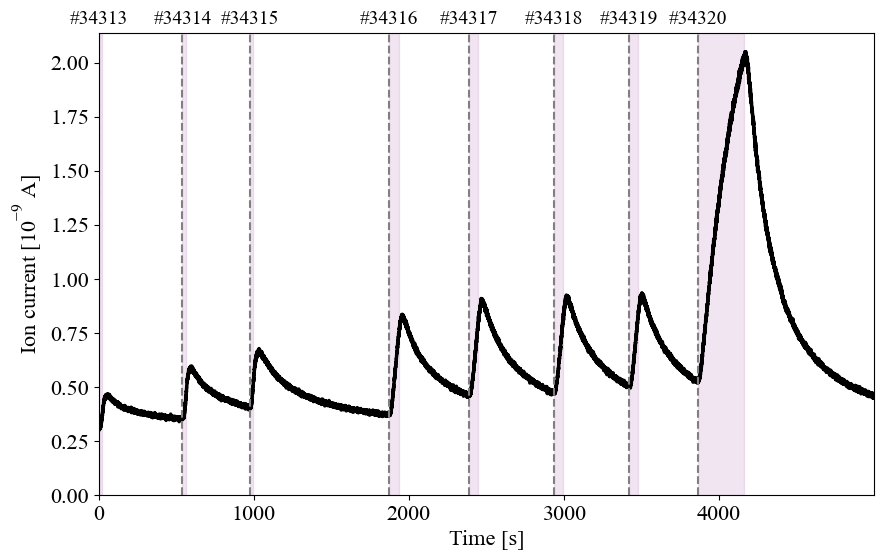

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(tsec, y_new/1e-9, color='k', markersize=2, linewidth=2.5)

ax = plt.gca()

for i in range(len(shot_list)):
    start = float(shot_start_list[i]) - x_new[0]
    duration = float(shot_duration[i])
    plt.axvline(x=start, color='grey', linestyle='--',)
    plt.axvspan(start, start+duration, color='purple', alpha=0.1)


    value = int(shot_start_list[i])  # ← 表示したい5桁の数字
    ax.text(
        start, 1.05,
        f"#{shot_list[i]}",
        transform=ax.get_xaxis_transform(),
        ha="center", va="top",
        fontsize=14
    )


plt.tick_params(labelsize=16)
plt.xlabel("Time [s]", fontsize=16)
plt.ylabel(r'Ion current [$10^{-9}$ A]', fontsize=16)

plt.xlim(0, tsec[-1])
plt.ylim(0)

plt.show()

In [53]:
# 排気遅れの計算は省略
y_perm = y_new*kqms[8]/A[8] 

34313開始時の透過流束：1.94e+13
34313開始時の金属膜内の濃度：6.23e+21


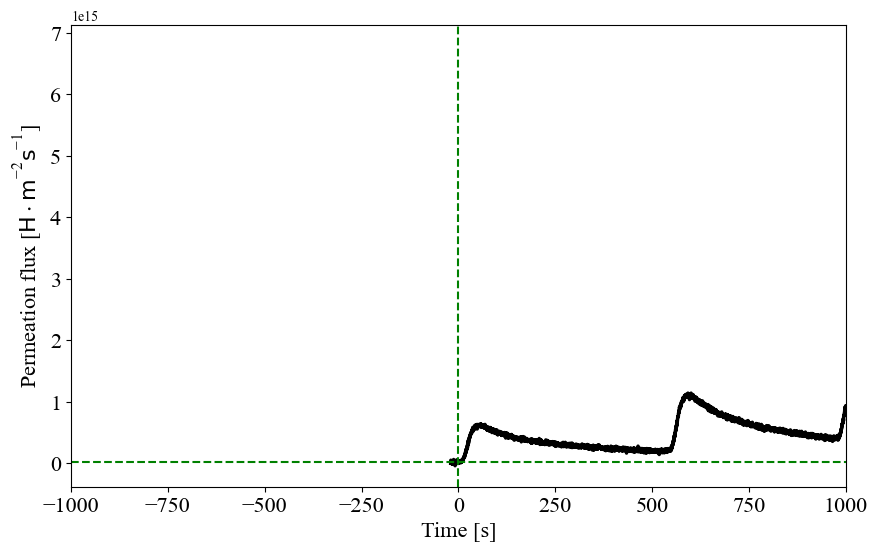

34314開始時の透過流束：2.06e+14
34314開始時の金属膜内の濃度：2.03e+22


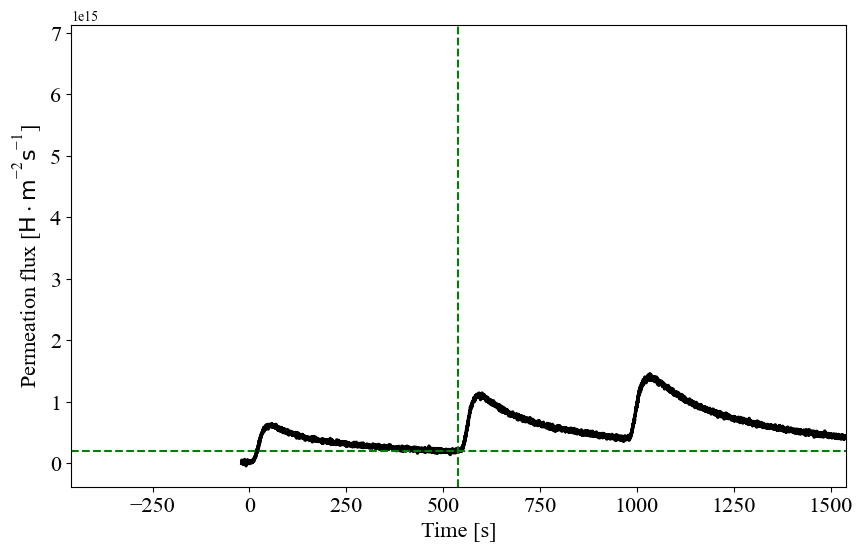

34315開始時の透過流束：4.07e+14
34315開始時の金属膜内の濃度：2.85e+22


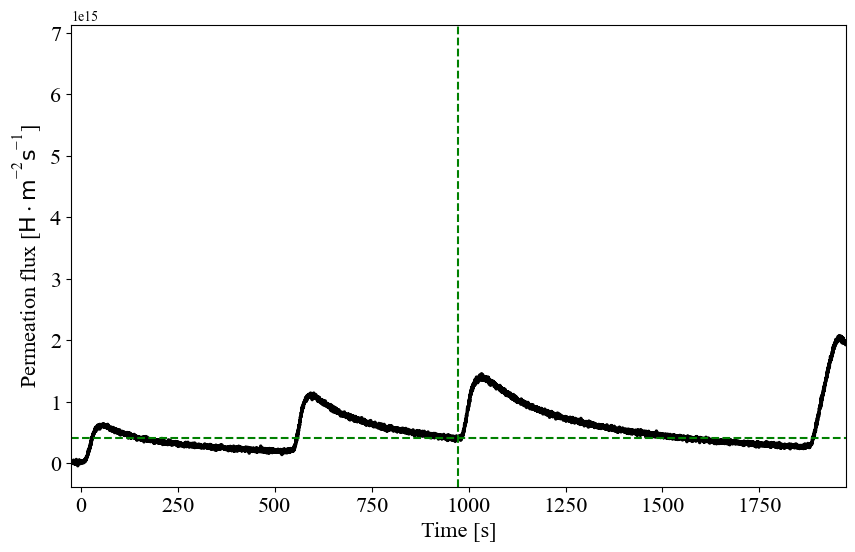

34316開始時の透過流束：2.64e+14
34316開始時の金属膜内の濃度：2.30e+22


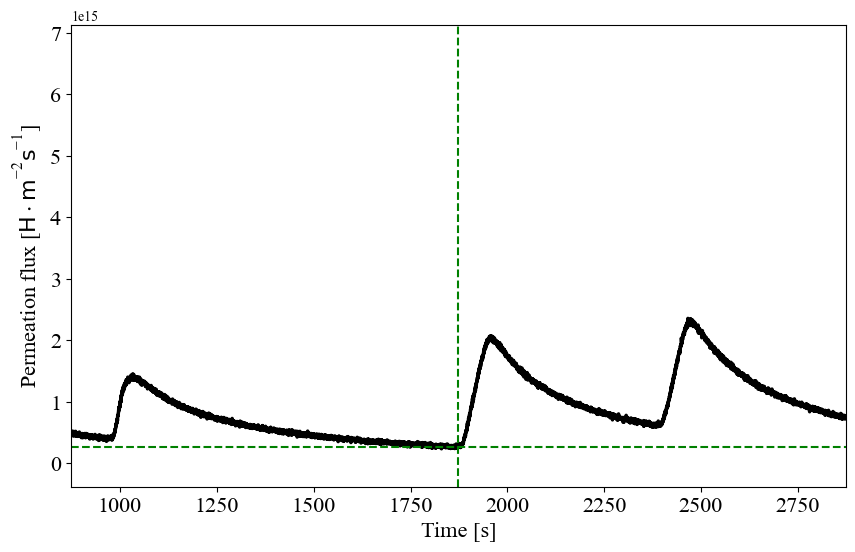

34317開始時の透過流束：6.09e+14
34317開始時の金属膜内の濃度：3.49e+22


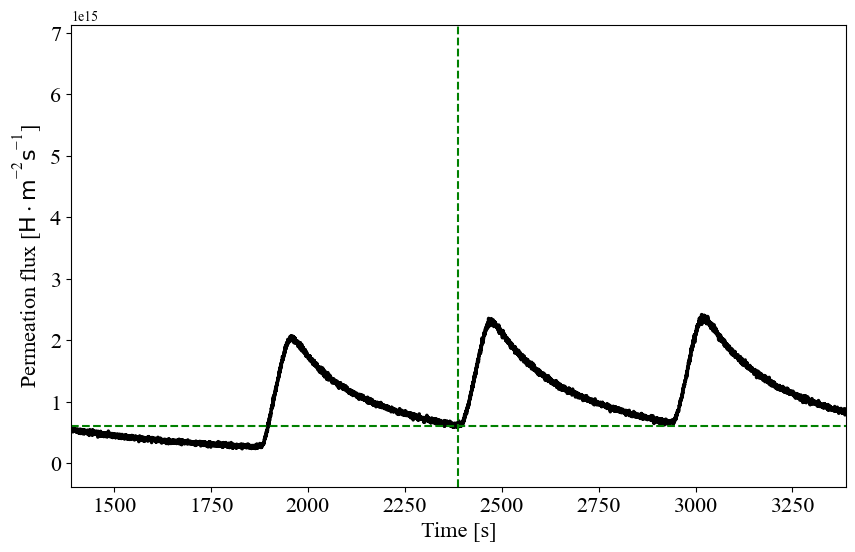

34318開始時の透過流束：6.83e+14
34318開始時の金属膜内の濃度：3.70e+22


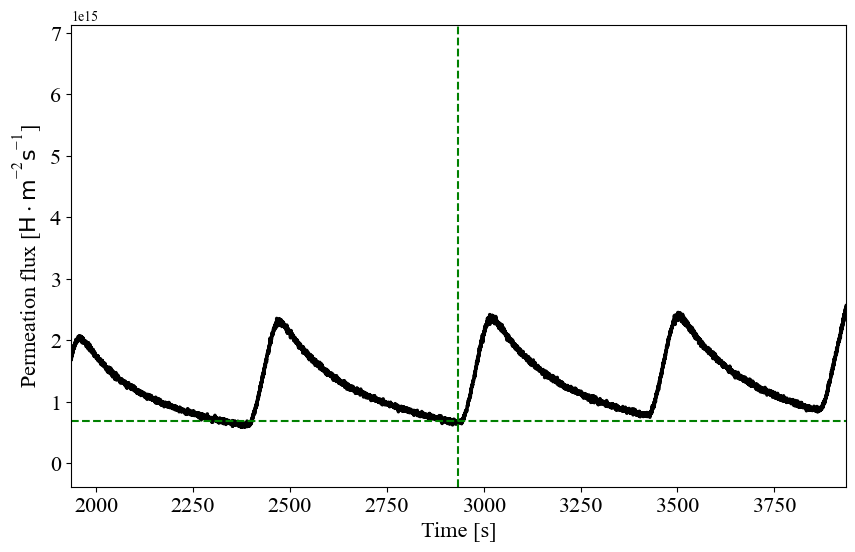

34319開始時の透過流束：7.99e+14
34319開始時の金属膜内の濃度：4.00e+22


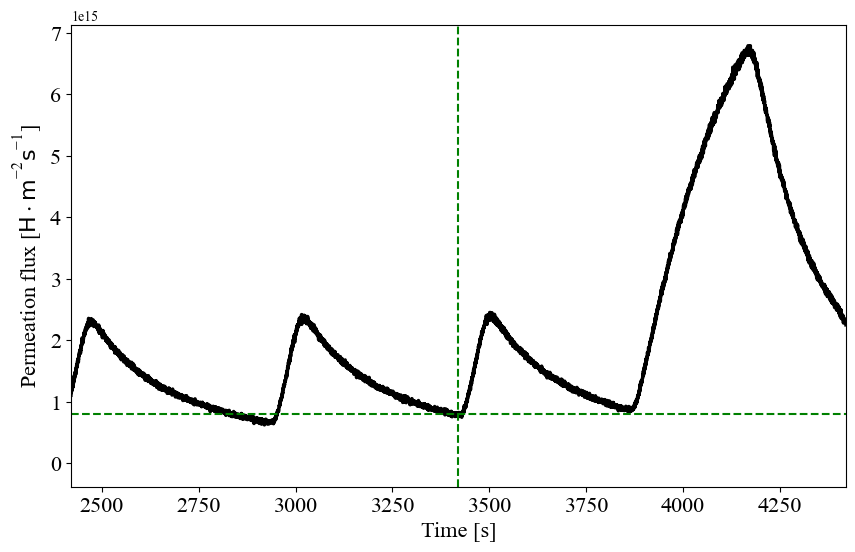

34320開始時の透過流束：8.54e+14
34320開始時の金属膜内の濃度：4.13e+22


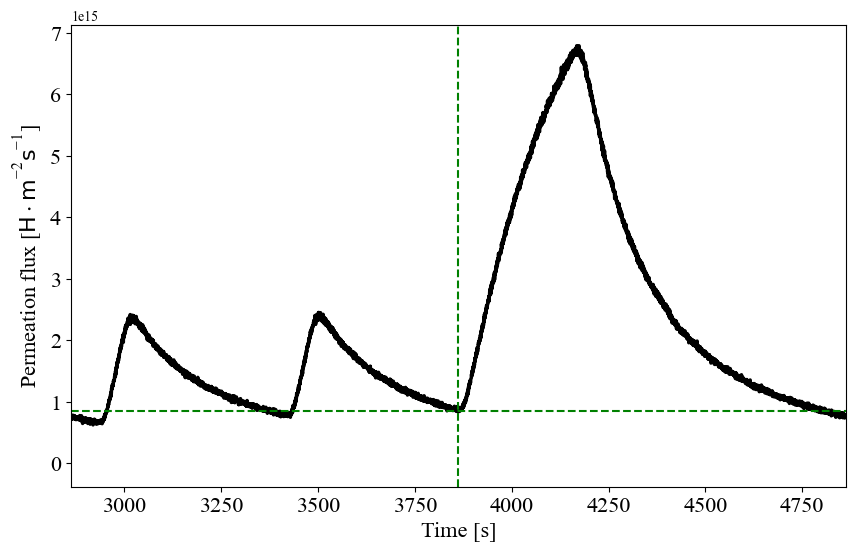

In [54]:
for target_shot in shot_list:
    df_perm = pd.read_csv(join(pp_pth,f'{target_shot} PDP 8.txt'),delimiter='\t')
    perm_time = df_perm[df_perm.columns[2]][0]
    perm_time = t2sa([perm_time])

    perm_time -= x_new[0]
    
    idx = (np.abs(tsec - perm_time)).argmin()
    target_y = y_perm[idx] - y_perm[0]
    solute = np.sqrt(target_y/kd)

    plt.figure(figsize=(10, 6))

    plt.plot(tsec, y_perm-y_perm[0], color='k', markersize=2, linewidth=2.5)
    plt.axvline(x=perm_time, color='green', linestyle='--',)

    plt.axhline(y=target_y, color='green', linestyle='--',)

    plt.tick_params(labelsize=16)

    plt.xlabel("Time [s]", fontsize=16)
    plt.ylabel(r'Ion current [$10^{-9} \ \mathrm{A}$]', fontsize=16)
    plt.ylabel(rf'Permeation flux [$\mathrm{{H}} \cdot \mathrm{{m}}^{{-2}} \mathrm{{s}}^{{-1}}$]', fontsize=16)

    print(f'{target_shot}開始時の透過流束：{target_y:.2e}')
    print(f'{target_shot}開始時の金属膜内の濃度：{solute:.2e}')

    plt.xlim(perm_time - 1000, perm_time + 1000)

    plt.show()